# Introduction : Business case

Your client is a mental health expert from an NGO who is interested in understanding more about gaming and the potentially addictive effect it can have on some individuals. You are meeting the client in a few days and they would like you to extract and present insights from the Steam dataset to help them in their research.

### Goals :
I)   We have to find a metric with which we can quatify the addiction. 

II)  We have to analyse the distribution of this metric subject to our sample (gamers).

III) Analyse the different aspects of games and to what extent they contibute to the addiction.

IV)  Propose a Model that explains the addiction given some features.

### The Metric:

The metric that we will use to quantify addiction is the time spend playing. In the Games_1, Games_2 datasets we have a feature `playtime_forever`that contains the time spend playing a given game by a given user. It could be optimal if we had a variable that gives us the playtime per day or per week, to see the repartition of the playing time. `Playtime_2weeks`is full of missing values so I prefered using the cumulated time playing. 

# Libraries :

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from scipy import stats
from IPython.display import display

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import col, udf, explode, rank, unix_timestamp, from_unixtime, split
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
import numpy as np

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G'), # setup
                                   ('spark.sql.broadcastTimeout',  '1000')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))


## Data Wrangling :
In this part we will gather all information that we believe it will be relevent to our model.

In [3]:
# Information about datasets
def info(df,show=True,n=2):
    print("Number of columns: ",len(df.columns))
    print("Number of rows: ", df.count())
    print("Name of columns and types:", df.dtypes)
    if show:
        df.show(n)   

### Games_1, Games_2 :

In [4]:
game_1 = spark.read.csv('data/Games_1.csv', header=True)
info(game_1,True,5)

Number of columns:  5
Number of rows:  628117
Name of columns and types: [('steamid', 'string'), ('appid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string')]
+-----------------+------+---------------+----------------+--------------------+
|          steamid| appid|playtime_2weeks|playtime_forever|       dateretrieved|
+-----------------+------+---------------+----------------+--------------------+
|76561198001291264|  8870|           null|            1392|2013-06-09 01:01:...|
|76561198001291264|   400|           null|             239|2013-06-09 01:01:...|
|76561198001291264|212910|           null|             130|2013-06-09 01:01:...|
|76561198001291264|   550|           null|           17547|2013-06-09 01:01:...|
|76561198001291264|   420|           null|             534|2013-06-09 01:01:...|
+-----------------+------+---------------+----------------+--------------------+
only showing top 5 rows



In [5]:
game_2 = spark.read.csv('data/Games_2.csv', header=True)
info(game_2,True,5)

Number of columns:  5
Number of rows:  1200557
Name of columns and types: [('steamid', 'string'), ('appid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string')]
+-----------------+-----+---------------+----------------+--------------------+
|          steamid|appid|playtime_2weeks|playtime_forever|       dateretrieved|
+-----------------+-----+---------------+----------------+--------------------+
|76561197973546950|   70|           null|              86|2014-08-16 18:25:...|
|76561197973532552|65610|           null|               7|2014-08-16 18:26:...|
|76561197973497160|  280|           null|             731|2014-08-16 18:28:...|
|76561197973529600|26800|           null|              39|2014-08-16 18:28:...|
|76561197973529600|49540|           null|              95|2014-08-16 18:28:...|
+-----------------+-----+---------------+----------------+--------------------+
only showing top 5 rows



In [6]:
### Concatenating Game_1 and Game_2:
game = game_1.union(game_2)
info(game)

Number of columns:  5
Number of rows:  1828674
Name of columns and types: [('steamid', 'string'), ('appid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string')]
+-----------------+-----+---------------+----------------+--------------------+
|          steamid|appid|playtime_2weeks|playtime_forever|       dateretrieved|
+-----------------+-----+---------------+----------------+--------------------+
|76561198001291264| 8870|           null|            1392|2013-06-09 01:01:...|
|76561198001291264|  400|           null|             239|2013-06-09 01:01:...|
+-----------------+-----+---------------+----------------+--------------------+
only showing top 2 rows



## User oriented playing time :

In [7]:
user_oriented = game.groupBy('steamid').agg(countDistinct('appid').alias('number of games')\
                                            ,mean('playtime_forever').alias('playtime_per_game')).toPandas()
user_oriented.head()

,steamid,number of games,playtime_per_game
0,76561197973784324,72,457.525926
1,76561198027864348,10,375.333333
2,76561197972510274,149,741.345000
3,76561198001205398,18,625.677419
4,76561197972024750,40,2987.872727


#### Ditribution of playing time over gamers :

The mean average play time per game (min) 2383.456691485273
The median average play time per game(min) 448.3333333333333


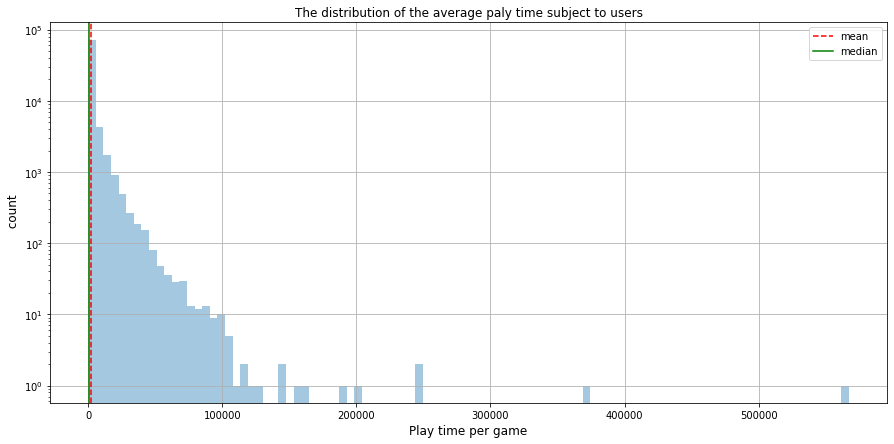

In [8]:
plt.figure(figsize=(15,7))
ax =sns.distplot(user_oriented['playtime_per_game'], hist=True, kde=False, bins=100)
print('The mean average play time per game (min)',user_oriented['playtime_per_game'].mean())
print('The median average play time per game(min)',user_oriented['playtime_per_game'].median())
ax.axvline(user_oriented['playtime_per_game'].mean(), color='r', linestyle='--', label='mean')
ax.axvline(user_oriented['playtime_per_game'].median(), color='g', linestyle='-', label='median')
ax.set_yscale('log')
plt.grid()
plt.xlabel('Play time per game', size='large')
plt.ylabel(' count', size='large')
plt.title('The distribution of the average paly time subject to users')
plt.legend()
plt.show()

### Comments :

From the graph we can see a heavy tailed distribution and the presance of extreme values. Half of the sample plays around 450 minutes per game. However, some players spend on average more than 200000 per game which could be considered as addiction. In this study, we will inspect, game wise, the different aspects that affect the play time. Play time will be considered as our metric of addiction. We start by invetigating the distribution of play time over the games.

## Game oriented playing time :

We can extract the average time played on a game and the number of player from the previous dataframe.

In [9]:
Game_oriented = game.groupBy('appid').agg(countDistinct('steamid').alias('number_players')\
                                          ,mean('playtime_forever').alias('avg_playtime')\
                                          ,stddev('playtime_forever').alias('std')).toPandas()
Game_oriented.head()

,appid,number_players,avg_playtime,std
0,108800,2504,215.102035,536.676927
1,232050,159,1458.152632,8179.321011
2,240200,69,4.466667,23.465520
3,247020,167,273.654762,568.310080
4,45300,188,1084.280374,3518.112030


In [10]:
## Checking missing values :
print('The number of standard deviations with NaN value: ',len(Game_oriented[Game_oriented['std'].isnull()]))
print('The number of games with zero playing time: ',len(Game_oriented[Game_oriented['avg_playtime']==0]))
Game_oriented[Game_oriented['avg_playtime']==0].head(5)

The number of standard deviations with NaN value:  149
The number of games with zero playing time:  182


,appid,number_players,avg_playtime,std
9,39350,1,0.0,NaN
52,13660,2,0.0,0.0
58,274450,2,0.0,0.0
70,6820,11,0.0,0.0
108,292680,2,0.0,0.0


I believe that the zero avgerage playing time is due to missing values, The purpose of this study is to inspect addiction so we remove these values without affecting any result of our study.  

In [11]:
Game_oriented = Game_oriented[Game_oriented.avg_playtime != 0.0]

Some of the games appears only once in the dataset, so the standard deviation will be equal two zero. 

In [12]:
#replacing the NaN values in std by zero.
Game_oriented = Game_oriented.fillna(0)

To scale the average time, we can consider the upper bound of the 95% confidence interval or the lower one. Our choice will depend on our intention, we can se the maximum value that the playtime could reach with a 0.95 probability: We will use the quantile $q$= 1,96

In [13]:
q=1.96
# The upper bound of the confidence interval
Game_oriented['upper'] = Game_oriented.apply( lambda x : x['avg_playtime'] + q*(x['std']/np.sqrt(x['number_players'])), axis=1)
Game_oriented = Game_oriented.fillna(Game_oriented.median())

In [14]:
Game_oriented.head()

,appid,number_players,avg_playtime,std,upper
0,108800,2504,215.102035,536.676927,236.122960
1,232050,159,1458.152632,8179.321011,2729.530837
2,240200,69,4.466667,23.465520,10.003503
3,247020,167,273.654762,568.310080,359.849984
4,45300,188,1084.280374,3518.112030,1587.186368


The mean average play time (min) 842.7082774772853
The median average play time (min) 202.64774789262373


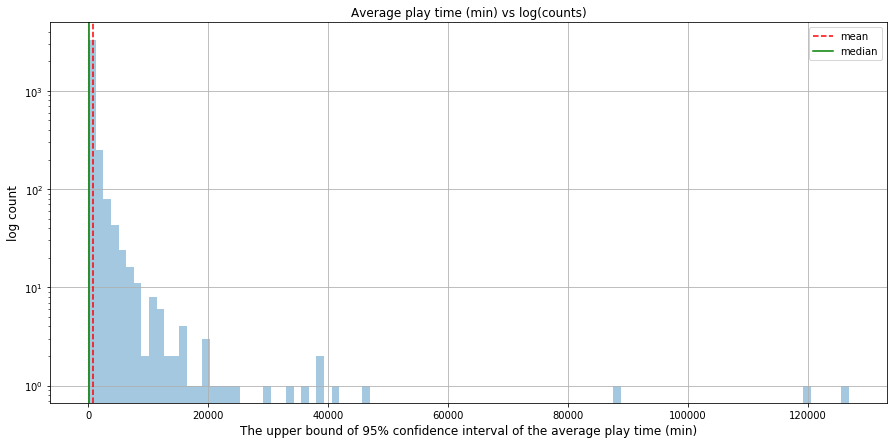

In [15]:
### Plotting the histogram of average play time
plt.figure(figsize=(15,7))
ax =sns.distplot(Game_oriented['upper'], hist=True, kde=False,bins=100)
print('The mean average play time (min)',Game_oriented['upper'].mean())
print('The median average play time (min)',Game_oriented['upper'].median())
ax.axvline(Game_oriented['upper'].mean(), color='r', linestyle='--', label='mean')
ax.axvline(Game_oriented['upper'].median(), color='g', linestyle='-', label='median')
ax.set_yscale('log')
plt.grid()
plt.xlabel('The upper bound of 95% confidence interval of the average play time (min)', size='large')
plt.ylabel('log count', size='large')
plt.title('Average play time (min) vs log(counts)')
plt.legend()
plt.show()

We can see that the upper bound of the average play time follows a power low. There are some extreme values : more than 120000 minutes which is equivalent to 833 days which is a sign of addiction. It is interesting to study the variation in those values subject to the caracteristics of a given game. In the next Section we will study to following questions:

###  Does the genre of the game impacts the play time ?
###  Does the Multiplayer mode impacts the play time ?
###  Is there association between percentage achievement and play time ?
### Does some words in the title of the game affect the play time ?

## Genres :

In [16]:
## the genre data set :
genres = spark.read.csv('data/Games_Genres.csv', header = True)
info(genres)

Number of columns:  2
Number of rows:  39669
Name of columns and types: [('appid', 'string'), ('Genre', 'string')]
+-----+-----+
|appid|Genre|
+-----+-----+
| 7290|  RPG|
| 8980|  RPG|
+-----+-----+
only showing top 2 rows



In [17]:
# Joining game dataset with genre :
game_genre = game.join( genres, on='appid', how='left')
info(game_genre)

Number of columns:  6
Number of rows:  3004439
Name of columns and types: [('appid', 'string'), ('steamid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string'), ('Genre', 'string')]
+-----+-----------------+---------------+----------------+--------------------+------+
|appid|          steamid|playtime_2weeks|playtime_forever|       dateretrieved| Genre|
+-----+-----------------+---------------+----------------+--------------------+------+
| 8870|76561198001291264|           null|            1392|2013-06-09 01:01:...|Action|
|  400|76561198001291264|           null|             239|2013-06-09 01:01:...|Action|
+-----+-----------------+---------------+----------------+--------------------+------+
only showing top 2 rows



In [18]:
## Romoving games without genre :
Filtered_game_genre=game_genre.where(game_genre.Genre.isNotNull())

## Counting the the play time subject to the genre
## Since for each genre the appid is present at most once, we can proceed as follows:
game_genre_grouped = Filtered_game_genre.groupBy('genre').agg(count('steamid').alias('number of players')\
                                                    ,mean('playtime_forever').alias('avg_playtime')\
                                                    ,stddev('playtime_forever').alias('std')).toPandas()
game_genre_grouped.head()

,genre,number of players,avg_playtime,std
0,Education,427,925.161593,8300.255574
1,Massively Multiplayer,28432,2090.806595,8720.665554
2,Adventure,279027,583.042102,2280.933534
3,Sports,14807,712.806075,4063.601702
4,Accounting,179,3412.398876,18790.865006


### Plotting :

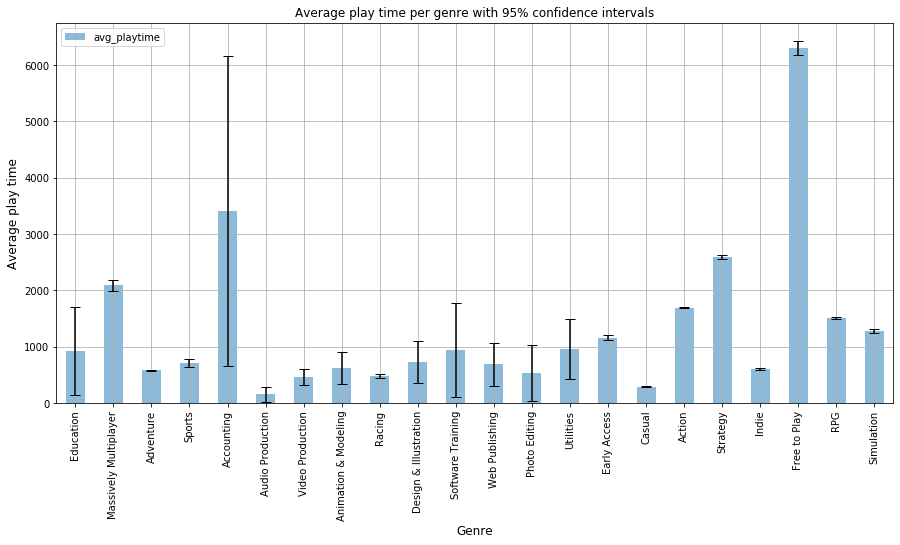

In [19]:
q = 1.96 # the 0.95 quantile of the normal distribution

game_genre_grouped['Error'] = q * game_genre_grouped["std"] / np.sqrt(game_genre_grouped["number of players"])

game_genre_grouped.plot(kind='bar', x='genre', y='avg_playtime', yerr = 'Error', alpha=0.5, capsize=5, 
               figsize=(15,7))
plt.grid()
plt.xlabel("Genre", size='large')
plt.ylabel("Average play time", size="large")
plt.title("Average play time per genre with 95% confidence intervals", size="large")
plt.show();


### Comments:

Free to play genre has the largest time spent playing followed by accounting games. Accounting games is a new VR games lunched on steam VR on 2016. The confident interval of Accounting game is too large, so we cannot really rely on the value of the average. Massively Multiplayer and strategy games have an average time around 2300 min. Still, we need to inspect the variance around the average value to see if there are some extreme cases:

### Plotting the standard deviance :

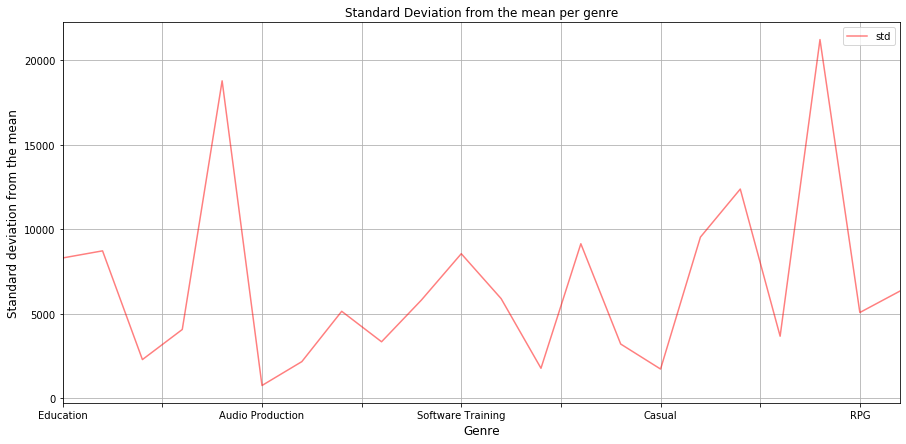

In [20]:
game_genre_grouped.plot(x='genre', y='std', alpha=0.5, figsize=(15,7), c='r')
plt.grid()
plt.xlabel("Genre", size='large')
plt.ylabel("Standard deviation from the mean", size="large")
plt.title("Standard Deviation from the mean per genre", size="large")
plt.show();


What we can conclude from the standard deviation graph is that:

* Free to play category contains extreme values since the deviation from the mean is high (more than 20000 minutes). In addition, Accounting has a significant standard deviation that needs to be considered in the analysis. 

## Multiplayer Mode:

In [21]:
### Reading dataset:
App_id = spark.read.csv('data/App_ID_Info.csv', header = True)
info(App_id)

Number of columns:  8
Number of rows:  17783
Name of columns and types: [('appid', 'string'), ('Title', 'string'), ('Type', 'string'), ('Price', 'string'), ('Release_Date', 'string'), ('Rating', 'string'), ('Required_Age', 'string'), ('Is_Multiplayer', 'string')]
+------+-------------------+----+-----+--------------------+------+------------+--------------+
| appid|              Title|Type|Price|        Release_Date|Rating|Required_Age|Is_Multiplayer|
+------+-------------------+----+-----+--------------------+------+------------+--------------+
|392230|Littlstar VR Cinema|game|    0|1970-01-01 00:00:...|    -1|           0|             0|
|440000| Portal 2: Exhumaos| mod|    0|1970-01-01 00:00:...|    -1|           0|             0|
+------+-------------------+----+-----+--------------------+------+------------+--------------+
only showing top 2 rows



In [22]:
## How may Multiplayer games:
Multiplayer = App_id.where(App_id.Is_Multiplayer==1)

In [23]:
info(Multiplayer)

Number of columns:  8
Number of rows:  5522
Name of columns and types: [('appid', 'string'), ('Title', 'string'), ('Type', 'string'), ('Price', 'string'), ('Release_Date', 'string'), ('Rating', 'string'), ('Required_Age', 'string'), ('Is_Multiplayer', 'string')]
+------+-------------+----+-----+--------------------+------+------------+--------------+
| appid|        Title|Type|Price|        Release_Date|Rating|Required_Age|Is_Multiplayer|
+------+-------------+----+-----+--------------------+------+------------+--------------+
|428230|        Swift|game|    0|1970-01-01 00:00:...|    -1|           0|             1|
|366310|The Crew Demo|demo|    0|1970-01-01 00:00:...|    71|           0|             1|
+------+-------------+----+-----+--------------------+------+------------+--------------+
only showing top 2 rows



In [24]:
## Joining to the gaming dataset:
game_multi = game.join(App_id, on= 'appid', how = 'left')
info(game_multi,False)

Number of columns:  12
Number of rows:  1828674
Name of columns and types: [('appid', 'string'), ('steamid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string'), ('Title', 'string'), ('Type', 'string'), ('Price', 'string'), ('Release_Date', 'string'), ('Rating', 'string'), ('Required_Age', 'string'), ('Is_Multiplayer', 'string')]


Now, we will extract a multiplayer dataset and a non multiplayer one. In each of the datasets, we will analyse the variation of the playing time. Finally, we will compare the two result and verify if there is a relevent difference between the two sets.

In [25]:
# Multiplayer Mode
## Filtering :
Mult = game_multi.where(game_multi.Is_Multiplayer==1)

## Grouping  :

Mult_grouped = Mult.groupBy('appid').agg(countDistinct('steamid').alias('number_players')\
                                          ,mean('playtime_forever').alias('avg_playtime')\
                                          ,stddev('playtime_forever').alias('std')).toPandas()
## Checking missing values :
print('The total number of observations:', len(Mult_grouped))
### Replacing NaN values of std with zeros :
Mult_grouped = Mult_grouped.fillna(0)
print('The number of standard deviations with NaN value: ',len(Mult_grouped[Mult_grouped['std'].isnull()]))
print('The number of games with zero playing time: ',len(Mult_grouped[Mult_grouped['avg_playtime']==0]))
Mult_grouped[Mult_grouped['avg_playtime']==0].head(5)
Mult_grouped.isna().any()
Mult_grouped.head()

The total number of observations: 1087
The number of standard deviations with NaN value:  0
The number of games with zero playing time:  21


,appid,number_players,avg_playtime,std
0,232050,159,1458.152632,8179.321011
1,9030,341,9.212987,47.127170
2,283100,3,769.000000,912.858697
3,44350,459,782.343525,1317.774051
4,243470,451,1766.607539,2195.062637


In [26]:
# No multiplayer Mode
## Filtering :
No_Mult = game_multi.where(game_multi.Is_Multiplayer==0)

## Grouping  :

No_Mult_grouped = No_Mult.groupBy('appid').agg(countDistinct('steamid').alias('number_players')\
                                          ,mean('playtime_forever').alias('avg_playtime')\
                                          ,stddev('playtime_forever').alias('std')).toPandas()
## Checking missing values :
print('The total number of observations:', len(No_Mult_grouped))
### Replacing NaN values of std with zeros :
No_Mult_grouped = No_Mult_grouped.fillna(0)
print('The number of standard deviations with NaN value: ',len(No_Mult_grouped[No_Mult_grouped['std'].isnull()]))
print('The number of games with zero playing time: ',len(No_Mult_grouped[No_Mult_grouped['avg_playtime']==0]))
No_Mult_grouped[No_Mult_grouped['avg_playtime']==0].head(5)
No_Mult_grouped.isna().any()
No_Mult_grouped.head()

The total number of observations: 2335
The number of standard deviations with NaN value:  0
The number of games with zero playing time:  110


,appid,number_players,avg_playtime,std
0,108800,2504,215.102035,536.676927
1,247020,167,273.654762,568.310080
2,45300,188,1084.280374,3518.112030
3,208630,23,213.200000,323.726513
4,40340,10,1667.846154,3163.466818


To scale the values of `avg_playtime`, We will compare the upper bounds of the 95% confidence interval for each game and ech mode ( Multiplayer or not)

In [27]:
## The Multiplayer mode
Mult_grouped['upper'] = Mult_grouped.apply( lambda x : x['avg_playtime'] + q*(x['std']/np.sqrt(x['number_players'])), axis=1)
##  The non multiplayer mode
No_Mult_grouped['upper'] = No_Mult_grouped.apply( lambda x : x['avg_playtime'] + q*(x['std']/np.sqrt(x['number_players'])), axis=1)


Text(0, 0.5, 'Playing time in minutes')

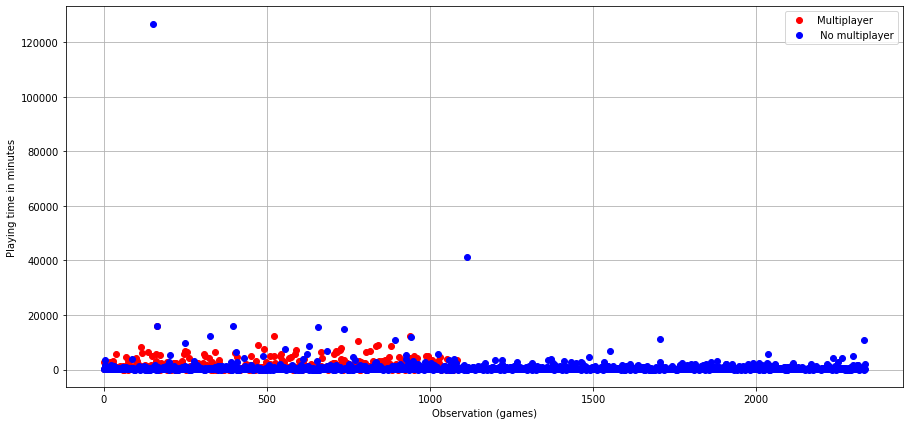

In [28]:
f,ax = plt.subplots(figsize=(15, 7))
plt.plot(Mult_grouped['upper'],'o',c='r', label='Multiplayer')
plt.plot(No_Mult_grouped['upper'],'o',c='b', label=' No multiplayer')
plt.grid()
ax.legend()
plt.xlabel('Observation (games)')
plt.ylabel('Playing time in minutes')


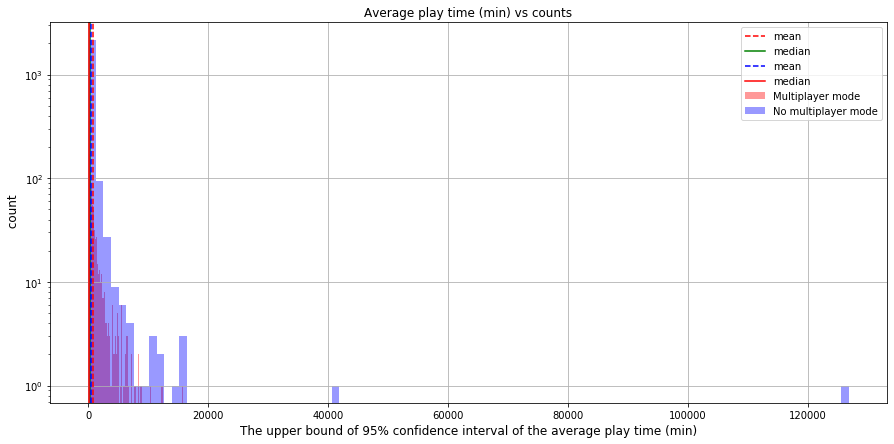

In [29]:
### Histogram plot:
plt.figure(figsize=(15,7))
ax=sns.distplot( Mult_grouped['upper'] ,hist=True,kde=False,bins=100, color="red", label="Multiplayer mode")
ax=sns.distplot( No_Mult_grouped['upper'], hist=True,kde=False,bins=100, color="blue", label="No multiplayer mode")
ax.axvline(Mult_grouped['upper'].mean(), color='r', linestyle='--', label='mean')
ax.axvline(Mult_grouped['upper'].median(), color='g', linestyle='-', label='median')
ax.axvline(No_Mult_grouped['upper'].mean(), color='b', linestyle='--', label='mean')
ax.axvline(No_Mult_grouped['upper'].median(), color='r', linestyle='-', label='median')
ax.set_yscale('log')
plt.grid()
plt.xlabel('The upper bound of 95% confidence interval of the average play time (min)', size='large')
plt.ylabel(' count', size='large')
plt.title('Average play time (min) vs counts')
plt.legend()
plt.show()

### Comments :
The different between the playing time in the multiplayer class and the non multiplayer class is not relevent. Maybe it is due to the lack of data, only 1000 observations of multiplayer. In the graph above we see some extreme playing times in the games without a multiplayer mode that reachs more than 120000 minutes. In general, we can't make a solid conclusion since the overlap between the two classes is big ( Histogram ).

## percentage achievement : 

Some games fix challenges so that the player continue to play the game until finishing all the challenges. We have a data set containing challenges of some games :

In [30]:
Ach_per = spark.read.csv('data/Achievement_percentages.csv', header=True)
info(Ach_per,True,10)

Number of columns:  3
Number of rows:  156253
Name of columns and types: [('appid', 'string'), ('Name', 'string'), ('Percentage', 'string')]
+-----+--------------------+----------+
|appid|                Name|Percentage|
+-----+--------------------+----------+
|   50|                ach0| 0.0910381|
|   50|                ach1| 0.0883079|
|   50|                ach2| 0.0884962|
|   50|            grp_ach0| 0.0107325|
|   50|            grp_ach1| 0.0106384|
|   60|        FinishedGame| 0.0617539|
|   60|      FoundEasterEgg| 0.0616356|
|   60|          Invincible|0.00692069|
|  220|HL2_BEAT_C1713STR...|   16.5448|
|  220|   HL2_BEAT_CEMETERY|   24.5443|
+-----+--------------------+----------+
only showing top 10 rows



We will group the observations by game (appid) and compute the number of challenges and the average percentage:

In [31]:
# joining to games:
ach_per_joined= Ach_per.join(game, on='appid', how='left')
info(ach_per_joined)

Number of columns:  7
Number of rows:  73443392
Name of columns and types: [('appid', 'string'), ('Name', 'string'), ('Percentage', 'string'), ('steamid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string')]
+------+----------+----------+-----------------+---------------+----------------+--------------------+
| appid|      Name|Percentage|          steamid|playtime_2weeks|playtime_forever|       dateretrieved|
+------+----------+----------+-----------------+---------------+----------------+--------------------+
|208630|Beady Eyes|   37.1938|76561197973402674|           null|            1032|2013-05-14 04:43:...|
|208630|Beady Eyes|   37.1938|76561198073676610|           null|             428|2013-09-17 04:01:...|
+------+----------+----------+-----------------+---------------+----------------+--------------------+
only showing top 2 rows



In [32]:
## Group by game 
ach_per_grouped = ach_per_joined.groupBy('appid').agg(countDistinct('Name').alias('number of challenges')\
                                              ,mean('Percentage').alias('avg_percentage')\
                                                ,mean('playtime_forever').alias('avg_playtime')).toPandas()
ach_per_grouped.head()

,appid,number of challenges,avg_percentage,avg_playtime
0,208630,16,27.318566,213.200000
1,232050,57,13.498362,1458.152632
2,247020,53,8.527746,273.654762
3,274560,19,6.694696,NaN
4,282680,19,1.026011,NaN


In [33]:
## removing null values
## since we are intersted in average playtime we can remove the observation or change it by a robust statistic.
print('The columns containing a null value :',ach_per_grouped.isnull().any())
## Since we have a high percentage for the games witout average playtime, we can replace the missing value by the 
## median of average playtime
ach_per_grouped = ach_per_grouped.fillna(ach_per_grouped.median())


The columns containing a null value : appid                   False
number of challenges    False
avg_percentage          False
avg_playtime             True
dtype: bool


In [34]:
## completed challenges
ach_per_grouped['challenges completed'] = ach_per_grouped.apply(lambda x : x['number of challenges']*x['avg_percentage']/100 , axis=1)

Now we will inspect the association between the number of challenges versus the avg_playtime, and the avg_percentage versus the avgerage playtime :

### Scatter plots :

Text(0.5, 1.0, 'Average play time (min) vs Number of challenges per game')

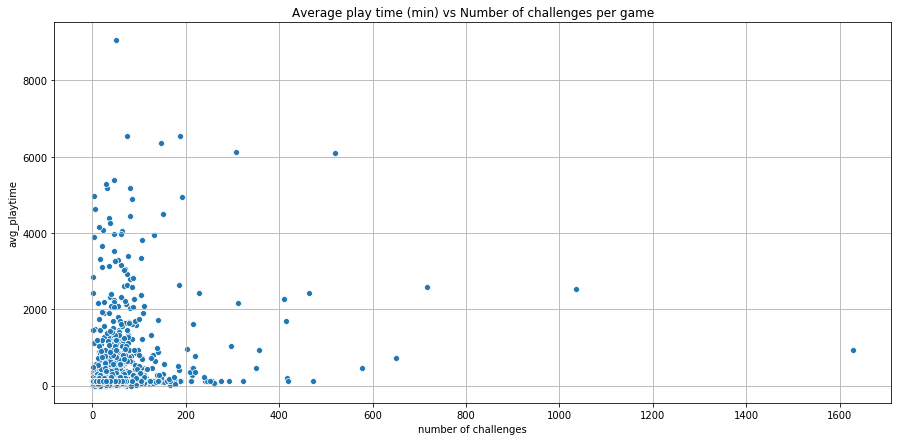

In [35]:
plt.figure(figsize=(15,7))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="number of challenges", y="avg_playtime", palette=cmap, data=ach_per_grouped)
plt.grid()
plt.title('Average play time (min) vs Number of challenges per game')

Text(0.5, 1.0, 'Average play time (min) vs Number of challenges per game')

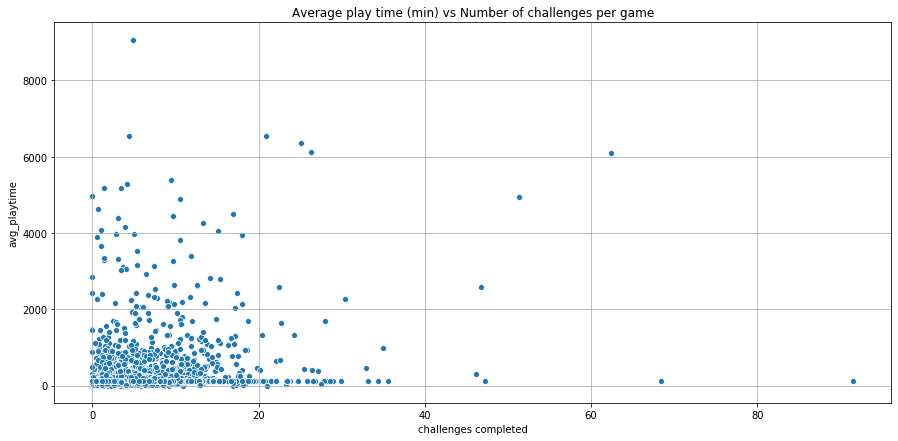

In [36]:
plt.figure(figsize=(15,7))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="challenges completed", y="avg_playtime", palette=cmap, data=ach_per_grouped)
plt.grid()
plt.title('Average play time (min) vs Number of challenges per game')

### Comments :

In the first plot, most of the games has less than 200 challenges. Thus, our conclusion will be biased since we don't have enough observations. What we can conclude : some games with a small number of challenges has a high playtime and some games with a high number of challenges have low average playtime.

# Title :

In [37]:
## Getting all the games with titles:
Titled = App_id.where(App_id.Title.isNotNull())
## Splitting the title :
split_col = split(Titled.Title, ' ')
Titled = Titled.withColumn('Title', split_col)
## Exploding
Titled = Titled.select(Titled.appid, explode(Titled.Title))
info(Titled)

Number of columns:  2
Number of rows:  80712
Name of columns and types: [('appid', 'string'), ('col', 'string')]
+------+---------+
| appid|      col|
+------+---------+
|392230|Littlstar|
|392230|       VR|
+------+---------+
only showing top 2 rows



In [38]:
## Taking the mean playtime for each game
game_oriented = game.groupBy('appid').agg(mean('playtime_forever').alias('playtime'))
## Joining with titles
game_title = Titled.join(game_oriented, on='appid', how='left')
info(game_title, False)

Number of columns:  3
Number of rows:  80712
Name of columns and types: [('appid', 'string'), ('col', 'string'), ('playtime', 'double')]


In [39]:
## Grouping words
title_grouped = game_title.groupBy('col').agg(countDistinct('appid').alias('nbr_games')\
                                             ,mean('playtime').alias('avg_playtime')).sort(desc('avg_playtime'))
## Cmputing the cumulated playing time for each word:
title_grouped = title_grouped.where(title_grouped.avg_playtime.isNotNull())
title_grouped = title_grouped.withColumn('cumulated_playtime', title_grouped.nbr_games*title_grouped.avg_playtime)
info(title_grouped,True,30)

Number of columns:  4
Number of rows:  4564
Name of columns and types: [('col', 'string'), ('nbr_games', 'bigint'), ('avg_playtime', 'double'), ('cumulated_playtime', 'double')]
+------------+---------+------------------+------------------+
|         col|nbr_games|      avg_playtime|cumulated_playtime|
+------------+---------+------------------+------------------+
|      Towers|        6|47145.666666666664|          282874.0|
|        Dota|       18|15377.396516632745| 276793.1372993894|
|    Eternity|       12|12068.699996229734| 144824.3999547568|
|     Mahjong|       10|10363.504639804638|103635.04639804638|
|      Cradle|        8| 9346.283333333335| 74770.26666666668|
|       Dogs:|       24| 9067.823529411764|217627.76470588235|
|         His|        9| 9067.823529411764| 81610.41176470587|
|        Each|        2| 9067.823529411764|18135.647058823528|
|        OMSI|       13|          7651.625|         99471.125|
|         EVE|        6| 6829.803786574871| 40978.82271944923|
|  

### Comments :
We see that some words are associated to well known games, like NBA, Mahjong, Dota. the word Dogs is present in 24 games cumulating 217627 min playing time. The word Towers also is present in 6 games with an average playing time 47145 minutes. So game conceptor could use these refrence words when shearching for a title to their new game.

# Modeling Play Time  :

In this part of the study, we will propose a model based on regression that explains the relation between playing time and some features related to games. We will begin by trying a linear model. We will use a ridge regression model with a regularization parameter $\lambda$ that we will optimise during the analysis. Second part, we will try to fit a random forest by varying the number of trees and choosing the optimal one based on the mean square error. 

Before fiting the model, we have to prepare our features. We will use different strategies to handle missing values without changing the distribution of the features.

The features that we will consider in our model are :

* The price of the game: App_id dataset
* the number of players playing the game: which is an indicator for the number op peaple that purchased the game.  dataset (union of game_1 and game_2)
* the number of challenges in the game: Achievement percentages dataset.
* Ratings (Metacritic) : App_id
* Multiplayer mode : categorical variable from App id.

The response variable:

* Playtime forever


## Data gathering :

In [40]:
## Ratings/Price/Mult
Rating_price_mult = App_id.select('appid','Price','Rating','Is_Multiplayer')
info(Rating_price_mult)

Number of columns:  4
Number of rows:  17783
Name of columns and types: [('appid', 'string'), ('Price', 'string'), ('Rating', 'string'), ('Is_Multiplayer', 'string')]
+------+-----+------+--------------+
| appid|Price|Rating|Is_Multiplayer|
+------+-----+------+--------------+
|392230|    0|    -1|             0|
|440000|    0|    -1|             0|
+------+-----+------+--------------+
only showing top 2 rows



In [41]:
## Number of challenges
Number_challenges = ach_per_joined.groupBy('appid').agg(countDistinct('Name').alias('number of challenges'))
info(Number_challenges)                                               

Number of columns:  2
Number of rows:  4721
Name of columns and types: [('appid', 'string'), ('number of challenges', 'bigint')]
+------+--------------------+
| appid|number of challenges|
+------+--------------------+
|208630|                  16|
|232050|                  57|
+------+--------------------+
only showing top 2 rows



In [42]:
## Number of players and Response variable
Number_of_players = game.groupBy('appid').agg(countDistinct('steamid').alias('number of players'),\
                                            mean('playtime_forever').alias('avg_playtime'))
info(Number_of_players)

Number of columns:  3
Number of rows:  3975
Name of columns and types: [('appid', 'string'), ('number of players', 'bigint'), ('avg_playtime', 'double')]
+------+-----------------+------------------+
| appid|number of players|      avg_playtime|
+------+-----------------+------------------+
|108800|             2504|215.10203461888855|
|232050|              159|1458.1526315789474|
+------+-----------------+------------------+
only showing top 2 rows



So we have only 3975 observation, in our data, with a label so when we will join the dataframes we will keep only the appid having a response variable:

In [43]:
## Data 
Data = Number_of_players.join(Number_challenges, on='appid', how='left').join(Rating_price_mult, on='appid', how='left')
Data = Data.toPandas()
Data.head()

,appid,number of players,avg_playtime,number of challenges,Price,Rating,Is_Multiplayer
0,108800,2504,215.102035,NaN,29.99,-1,0
1,207060,28,2499.122449,NaN,None,None,None
2,208630,23,213.200000,16.0,9.99,-1,0
3,232050,159,1458.152632,57.0,19.99,74,1
4,240200,69,4.466667,NaN,None,None,None


## Explanatory Analysis :

In this part we will deal with anomalies and missing values.

### Transforming price column :


In [44]:
Data.Price.unique()

array(['29.99', None, '9.99', '19.99', '14.99', '4.99', '5.99', '6.99',
       '7.99', '0', '59.99', '12.99', '2.99', '39.99', '0.99', '11.99',
       '24.99', '3.99', '13.37', '1.99', '21.99', '49.99', '8.99',
       '99.99', '13.99', '3.49', '44.99', '14.95', '17.99', '34.99',
       '6.49', '2.49', '15', '10.99', '18.99', '15.99', '16.99', '7.49',
       '59.95', '32.99', '69.99', '4.49', '79.99'], dtype=object)

We have to change all the string value to floats. We introduce a function that given a variable different from a null value it casts it to a float. We will do the same thing for the rating variable.

In [45]:
def Price_to (string):
     if (string != None):
        return  float(string)

In [46]:
Data['Price'] = Data.apply(lambda x: Price_to(x['Price']), axis=1)
Data.head()

,appid,number of players,avg_playtime,number of challenges,Price,Rating,Is_Multiplayer
0,108800,2504,215.102035,NaN,29.99,-1,0
1,207060,28,2499.122449,NaN,NaN,None,None
2,208630,23,213.200000,16.0,9.99,-1,0
3,232050,159,1458.152632,57.0,19.99,74,1
4,240200,69,4.466667,NaN,NaN,None,None


### Transforming the ratings column :

In [47]:
Data.Rating.unique()

array(['-1', None, '74', '64', '78', '69', '83', '77', '67', '62', '65',
       '80', '73', '87', '66', '76', '81', '61', '70', '60', '86', '68',
       '84', '75', '79', '85', '89', '72', '54', '48', '59', '57', '82',
       '51', '43', '90', '47', '20', '71', '56', '55', '49', '63', '88',
       '38', '22', '46', '94', '58', '45', '91', '39', '96', '92', '50',
       '52', '93', '41', '24', '37', '53', '44', '35', '95', '33', '40',
       '34', '27', '29', '30'], dtype=object)

In [48]:
def rating_int(rating):
    if (rating != None):
        return int(rating)

In [49]:
Data['Rating'] = Data.apply(lambda x: rating_int(x['Rating']), axis=1)
Data.head()

,appid,number of players,avg_playtime,number of challenges,Price,Rating,Is_Multiplayer
0,108800,2504,215.102035,NaN,29.99,-1.0,0
1,207060,28,2499.122449,NaN,NaN,NaN,None
2,208630,23,213.200000,16.0,9.99,-1.0,0
3,232050,159,1458.152632,57.0,19.99,74.0,1
4,240200,69,4.466667,NaN,NaN,NaN,None


### Missing values :
In this part, we will deal with missing values. We will try to fill the missing values based on the distribution of each column.

In [50]:
print('The number of missing values in each column')
Data.isna().sum()

The number of missing values in each column


appid                      0
number of players          0
avg_playtime               0
number of challenges    2291
Price                    553
Rating                   553
Is_Multiplayer           553
dtype: int64

We have to inspect the distribution of each feature so that we can decide how to fill the missing values in an optimal way.

In [51]:
## Plotting function that gives the ditribution of each feature
def create_hist(x, bins=20, xlabel='x', ylabel='Frequency', title=''):
    plt.figure(figsize=(15, 5))
    plt.hist(x, 20, edgecolor='Black',alpha=0.8)  # 20 number of bins
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

    plt.title('Histogram of ' + xlabel + ' ' + title)
    plt.show()


/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


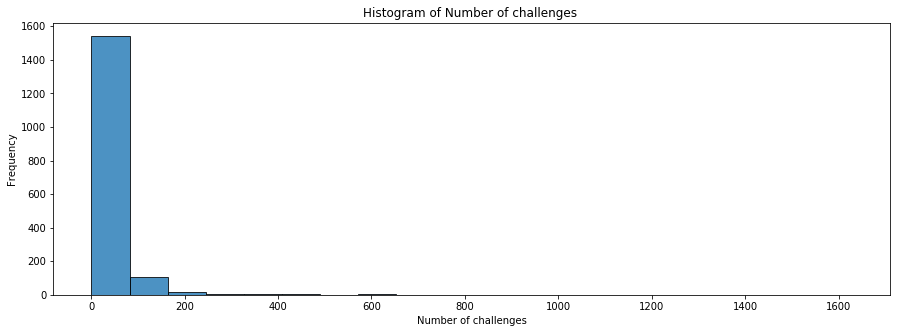

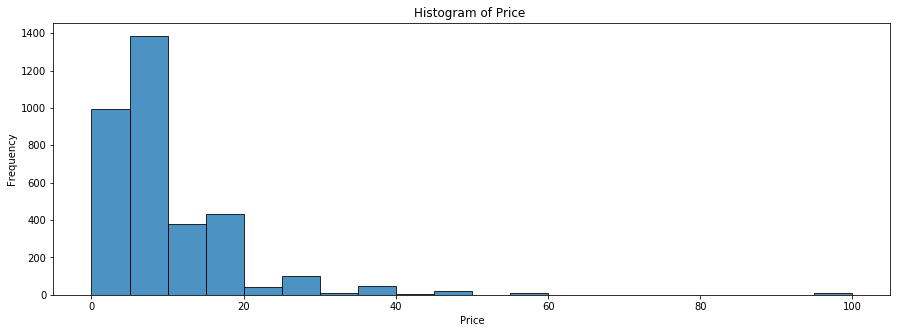

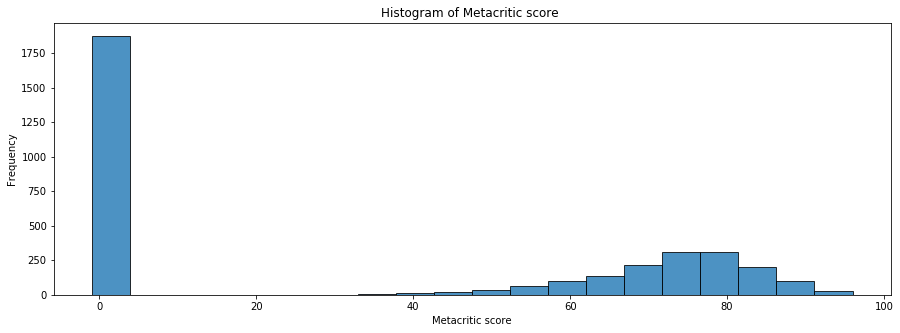

In [52]:
create_hist(Data["number of challenges"], 100, 'Number of challenges', 'Frequency')
create_hist(Data["Price"], 60, 'Price', 'Frequency')
create_hist(Data["Rating"], 60, 'Metacritic score', 'Frequency')


In [53]:
## The number of ones and zeros  :
Data['Is_Multiplayer'].value_counts()

0    2335
1    1087
Name: Is_Multiplayer, dtype: int64

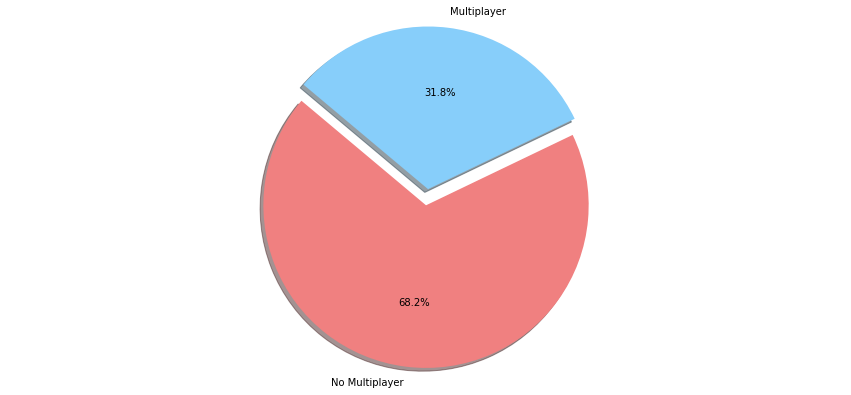

In [54]:
### Pie chart of the ratio of multiplayer vs no multiplayer.
plt.figure(figsize=(15,7))
# Data to plot
labels = 'No Multiplayer', 'Multiplayer'
sizes = [2335,1087]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Now we will try to fill the missing values in a optimal way based on probabilistic methods without changing the distribution of the features in the sample. For the multiplayer feature we will generate, for each missing value, a bernoulli variable with probability $p$=0.31 to be in the multiplayer class. In the case of the three other variables, we will use the average value to replace the null variable.

In [55]:
### Bernoullli generator:
def bernoulli(x,p):
    if (x == None):
        return np.random.binomial(1,p)
    else :
        return int(x)
       
        

In [56]:
### Replacing
Data['Is_Multiplayer'] = Data.apply(lambda x : bernoulli(x['Is_Multiplayer'],0.37), axis = 1)

In [57]:
### New values
Data['Is_Multiplayer'].value_counts()


0    2685
1    1290
Name: Is_Multiplayer, dtype: int64

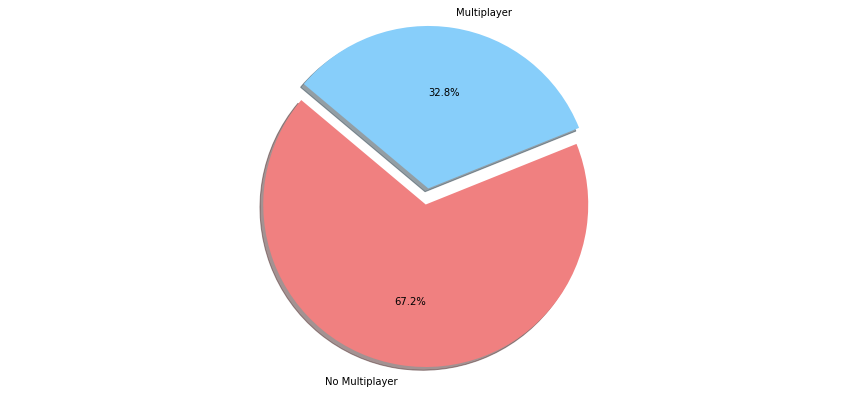

In [58]:
plt.figure(figsize=(15,7))
# Data to plot
labels = 'No Multiplayer', 'Multiplayer'
sizes = [2671,1304]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

The proportion is the same. For the number of challenges, Ratings and Price we will fill the missing values with mean value, since the tails of the distributions are not heavy:

In [59]:
Data['Rating'] = Data['Rating'].fillna(Data['Rating'].mean())
Data['Price'] = Data['Price'].fillna(Data['Price'].mean())
Data["number of challenges"] = Data["number of challenges"].fillna(Data["number of challenges"].mean())

In [60]:
Data.describe()

,number of players,avg_playtime,number of challenges,Price,Rating,Is_Multiplayer
count,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000
mean,302.026918,485.336131,43.071259,11.342016,32.357101,0.324528
std,1129.497379,1859.154056,43.951767,8.995137,34.768946,0.468257
min,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
25%,11.000000,34.583333,35.500000,5.990000,-1.000000,0.000000
50%,44.000000,116.872727,43.071259,9.990000,32.357101,0.000000
75%,179.000000,355.292683,43.071259,12.990000,70.000000,1.000000
max,21555.000000,54345.333333,1629.000000,99.990000,96.000000,1.000000


### Correlation matrix :
The correlation factor is an indicator of linear dependence. Since we will fit a linear model, it is necessary to inspect the linear relationship between the target variable and the features. The heatmab below shows no significant correlation between the target variable (avg_playtime) and the features. Maybe we will need some tranformations on the features.

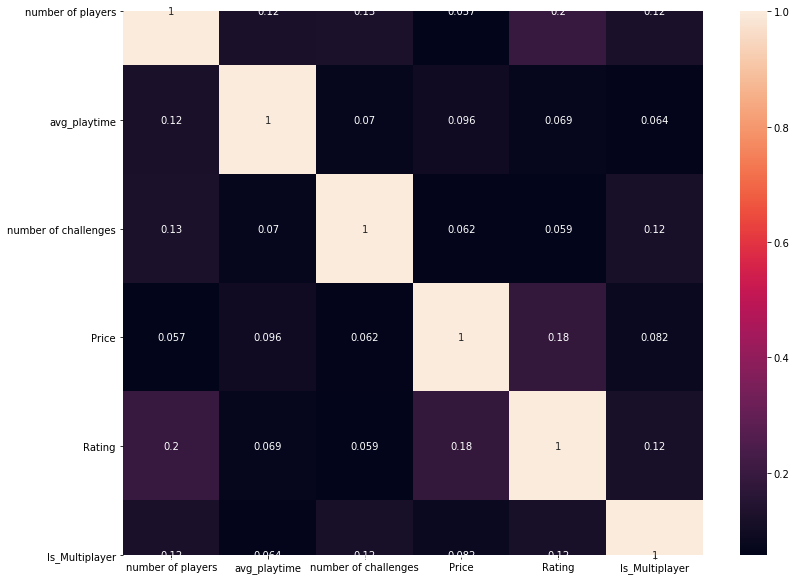

In [61]:
## Correlation heatmap :
plt.figure(figsize = (13,10))
sns.heatmap(Data.corr(), annot = True)

### Splitting features and response variables:

In [62]:
features = Data[['number of players','number of challenges','Price','Rating','Is_Multiplayer']]
Y = Data['avg_playtime']

### Standardization of the features:
We will need to standardize the features since they have a different order of magnitude. It will be easy to interpret the regression parameter with standardization.

In [63]:
#Standardize dataframe
def standardize(x):
    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(x, axis=0)
    
    return std_data


A target variable with a large spread of values, in turn, may result in large error gradient values causing weight values to change dramatically, making the learning process unstable. So we will standardize the target value too.

In [64]:
##we will not standardize the binary column Multiplayer
columns_std = ['number of players','number of challenges','Price','Rating']
features_std = standardize(features[columns_std])
features_std['Mult'] = features['Is_Multiplayer']
Y_std= standardize(Y)

In [65]:
features_std.head()

,number of players,number of challenges,Price,Rating,Mult
0,1.949761,1.552172e-14,2.073379e+00,-9.595142e-01,0
1,-0.242640,1.552172e-14,2.271302e-14,-9.401803e-15,0
2,-0.247067,-6.160086e-01,-1.503242e-01,-9.595142e-01,0
3,-0.126645,3.169496e-01,9.615275e-01,1.197854e+00,1
4,-0.206336,1.552172e-14,2.271302e-14,-9.401803e-15,0


### Train test split :

In [66]:
## We will use 30 percent of the data for the training:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(features_std, Y_std, test_size=0.3,random_state=1)

### Visualization :
#### Boxplots of features :
Boxplots give us insight about the distribution of the features (after the normalization)

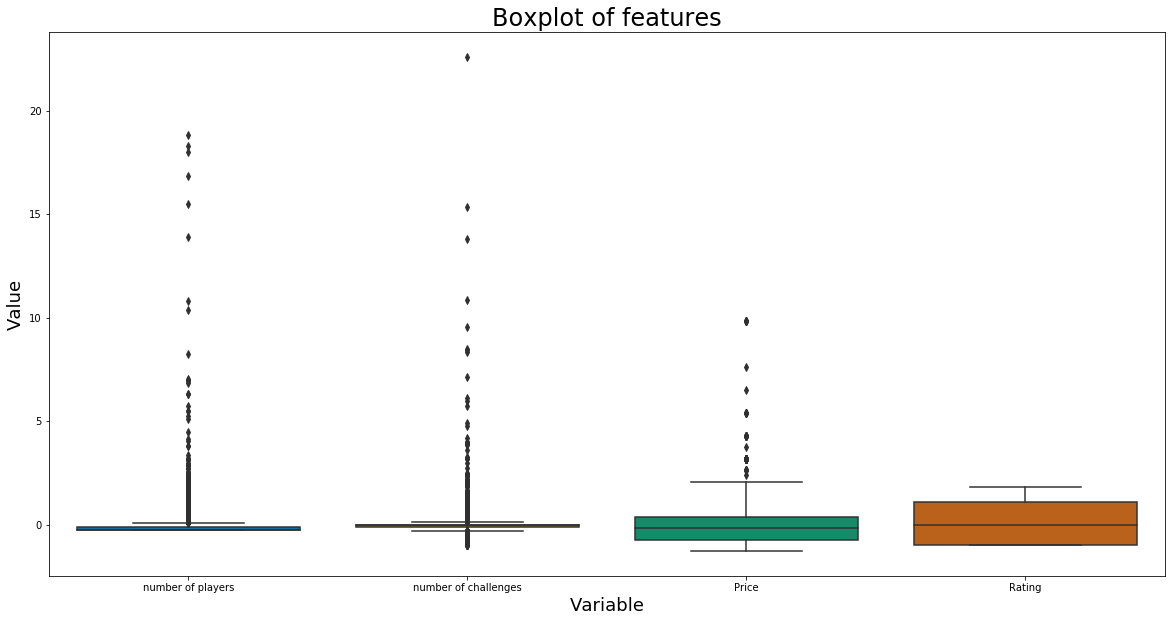

In [67]:
plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(X_train.iloc[:,0:4]), palette=sns.color_palette("colorblind"))

plt.xlabel("Variable", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.title("Boxplot of features", fontsize=24)

plt.show()

### Scatters :
Scatter plots will give insight about the relational function between the target variable and the features. we can see that there is not a sign of linearity. We think that the linear model will not give a significant result with those features. Maybe applying a transformation on the features ($log(number of players)$) will gives a better result

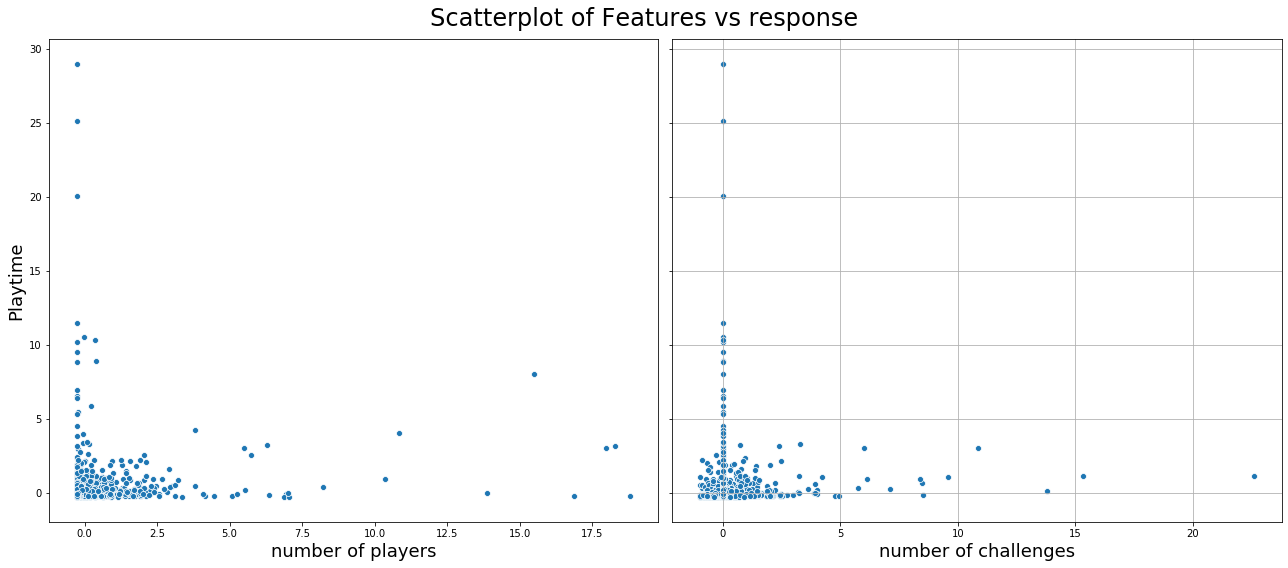

In [68]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

sns.scatterplot(X_train['number of players'], y_train, ax = ax1)
sns.scatterplot(X_train['number of challenges'], y_train, ax = ax2)
ax1.set_xlabel('number of players', fontsize=18)
ax1.set_ylabel('Playtime', fontsize=18)
ax2.set_xlabel('number of challenges', fontsize=18)
f.suptitle('Scatterplot of Features vs response', fontsize=24)
plt.grid()
f.tight_layout()
f.subplots_adjust(top=0.925)


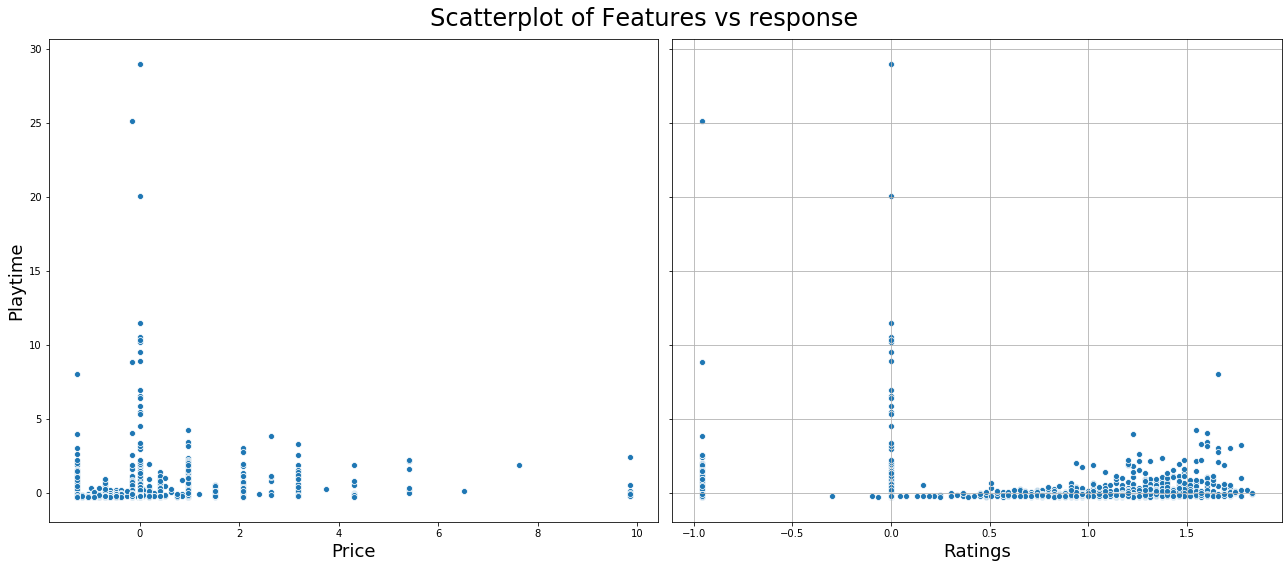

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

sns.scatterplot(X_train['Price'], y_train, ax = ax1)
sns.scatterplot(X_train['Rating'], y_train, ax = ax2)

ax1.set_xlabel('Price', fontsize=18)
ax1.set_ylabel('Playtime', fontsize=18)
ax2.set_xlabel('Ratings', fontsize=18)
f.suptitle('Scatterplot of Features vs response', fontsize=24)
plt.grid()
f.tight_layout()
f.subplots_adjust(top=0.925)

### Fitting a Ridge Regression mode :

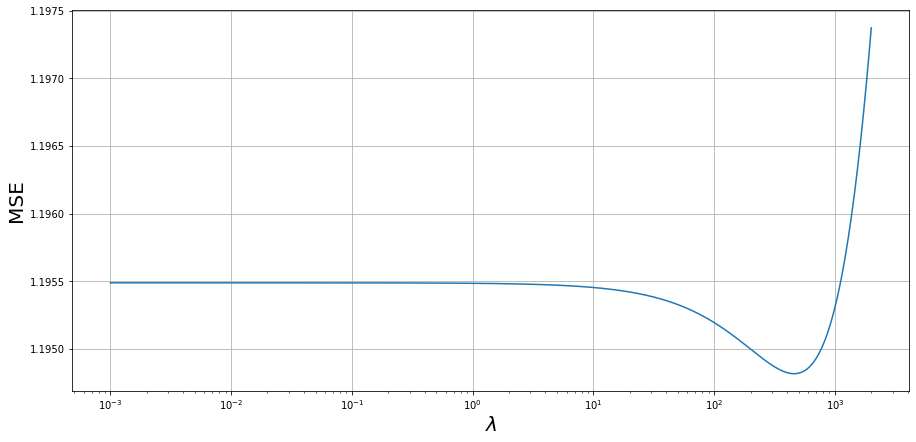

In [70]:
alphas = np.logspace(-3,np.log10(2000),1000) #We use logspace so we can start close to 0 

#If we have cv=none default scoring is MSE and k-fold cv is performed
regressor = RidgeCV(alphas=alphas, store_cv_values=True, cv=None) 
regressor.fit(X_train, y_train)

cv_mse = np.mean(regressor.cv_values_, axis=0)

plt.figure(figsize=(15,7))
plt.semilogx(alphas, cv_mse)
plt.grid()
plt.ylabel('MSE', fontsize=20)
plt.xlabel(r'$\lambda$', fontsize=20)

plt.show()

The best lambda is: 461.30581062421385
The MSE on the test data is: 0.4699280060619683


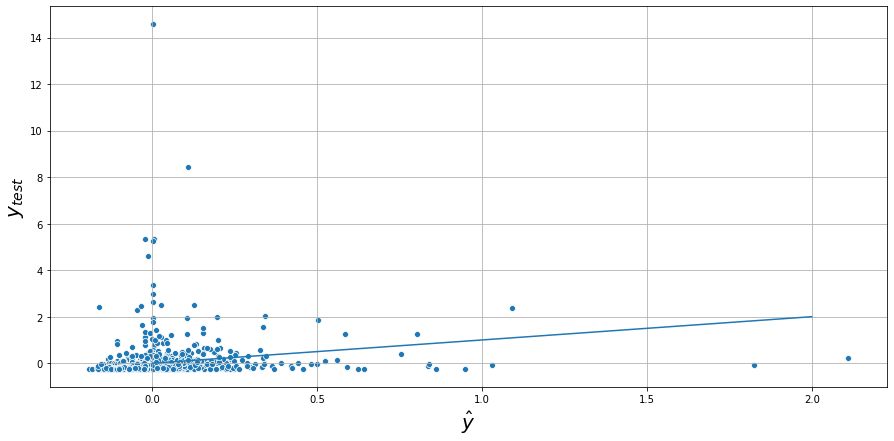

number of players       0.109312
number of challenges    0.060628
Price                   0.068706
Rating                  0.029892
Mult                    0.024301
dtype: float64


In [71]:
##Getting the best lambda :

base_lambda = regressor.alpha_
print('The best lambda is:', base_lambda)

##Prediction and performance on the test set :
y_hat = regressor.predict(X_test)
base_mse = mean_squared_error(y_test, y_hat)
print('The MSE on the test data is:', base_mse)

##plotting y hat vs y

plt.figure(figsize=(15,7))
sns.scatterplot(y_hat, y_test)
plt.grid()
plt.xlabel(r'$\hat{y}$', fontsize=20)
plt.ylabel(r'$y_{test}$', fontsize=20)
plt.plot([0,2],[0,2])
plt.show()

###printing the coefficients

w_star = pd.Series(data=regressor.coef_, index=X_train.columns)
print(w_star)


### Comments on ridge model:
The optimal regularization parameter $\lambda_{best}$ is 307.14 subject to the mean squared error.. The training error is 1.193 and the test error is 0.46. The final model has the following form:

$\bar{\hat{Y}} = 0.11\bar{X}_{number of players}+0.060471\bar{X}_{number of challenges } + 0.070253\bar{X}_{Price} +0.027580\bar{X}_{Rating} + 0.076256\bar{X}_{Mult }$

 Where the bar ($\hat{X}$) refers to standardized varibale.
 
 * The number of player has the highest parameter. One unit of standard deviation increase of the number of players will increase the avg_playtime by 0.11 std of playtime.
 
 * The plot showing the predicted values and the true ones is around the first bisector.




## Fitting  a random forest model :
In this part we will use the same features and the same training testing repartition to fit a non linear model. We will fit a random forest model with different number of trees and we will choose the optimal one subject to the mean squared error

In [72]:

Nbr_trees = [1,5,10,100,500,1000]
Mse = []
for n in Nbr_trees :
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = n, random_state = 42)

    ## Train the model on training data
    rf.fit(X_train, y_train)

    ## Use the forest's predict method on the test data
    y_hat_rf = rf.predict(X_test)

    ## MEan squarred error
    MSE_rf = mean_squared_error(y_test, y_hat_rf)
    Mse.append(MSE_rf)

print('Mean squared error :', Mse)


Mean squared error : [0.665420346849209, 0.6592756062063143, 0.656593413571053, 0.6227963717420724, 0.6209488172007086, 0.6158189628946589]


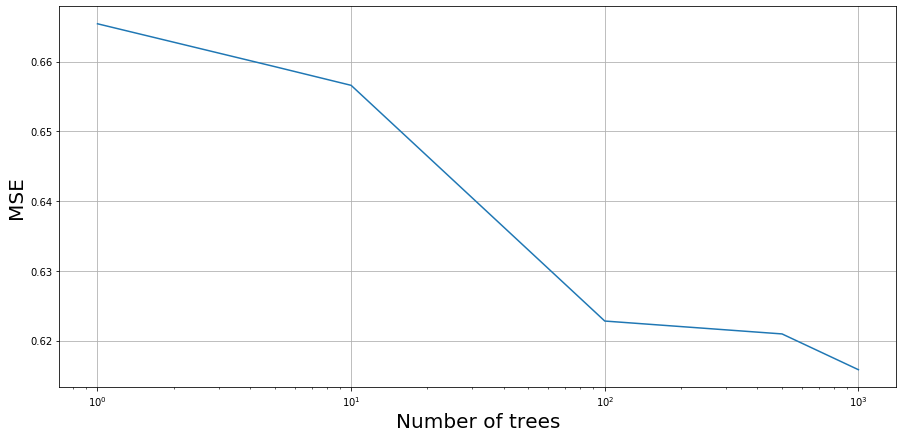

In [73]:
## plotting :
plt.figure(figsize=(15,7))
plt.semilogx(Nbr_trees, Mse)
plt.grid()
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Number of trees', fontsize=20)

plt.show()

* Increasing the number of trees will always decrease the training MSE since the compexity of the model is getting higher (Bias variance trade off). But there is a time where the MSE will be stable, in that moment we have to choose the least number of trees to reduce the complexity of the model.